In [5]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
input_size = 784
num_epochs = 50
batch_size = 100
sample_dir = "samples"
learning_rate_e = 0.0005
learning_rate_de = 0.0005
learning_rate_di = 0.0001
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = (0.5,0.5,0.5),
                        std = (0.5,0.5,0.5))])
data = torchvision.datasets.MNIST(root = 'Data', transform = transform, train = True, download= True)
data_loader = torch.utils.data.DataLoader(dataset = data, shuffle = True, batch_size= batch_size)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(784,400)
        self.fc2 = nn.Linear(400,100)
        self.fc3 = nn.Linear(100,2)
        self.relu = nn.ReLU()
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.relu(out)
        return (out)
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(2,100)
        self.fc2 = nn.Linear(100,400)
        self.fc3 = nn.Linear(400,784)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return (out)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(2,10)
        self.fc2 = nn.Linear(10,10)
        self.fc3 = nn.Linear(10,2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return(out)
model_encoder = Encoder().to(device)
model_decoder = Decoder().to(device)
model_discriminator = Discriminator().to(device)

criterion_discriminator = nn.BCELoss()
criterion_autoencoder = nn.L1Loss()

# params_ae = list(model_encoder.parameters())+list(model_decoder.parameters())
# params_d = list(model_encoder.parameters())+list(model_discriminator.parameters())

optimizer_encoder = torch.optim.Adam(model_encoder.parameters(), lr = learning_rate_e)
optimizer_discriminator = torch.optim.Adam(model_discriminator.parameters(), lr = learning_rate_di)
optimizer_decoder = torch.optim.Adam(model_decoder.parameters(), lr = learning_rate_de)



In [7]:
total_step = len(data_loader)
generator_loss = []
discriminator_loss = []
discriminator_acc = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(data_loader):
        acc = 0
        images = images.reshape(-1, 784).to(device)
        real_labels = torch.FloatTensor([0,1]*100).reshape((batch_size, 2)).to(device)
        fake_labels = torch.FloatTensor([1,0]*100).reshape((batch_size, 2)).to(device)
#         print(fake_labels)
        #Training autoencoder here 
        encoded = model_encoder(images)
        decoded = model_decoder(encoded)
        
        loss_encoder = 0.001*criterion_discriminator(model_discriminator(encoded), real_labels)+0.999*criterion_autoencoder(decoded, images)
        optimizer_encoder.zero_grad()
        loss_encoder.backward(retain_graph = True)
        optimizer_encoder.step()
        loss_decoder = criterion_autoencoder(decoded, images)
        optimizer_decoder.zero_grad()
        loss_decoder.backward(retain_graph=True)
        optimizer_decoder.step()
        #Training discriminator here
        z = torch.randn(batch_size, 2).to(device)
        real_output = model_discriminator(z)
        _, predicted_real = torch.max(real_output.data, 1)
        acc = (predicted_real == 1).sum()
#         print("The real output is: ", real_output)
        real_loss = criterion_discriminator(real_output, real_labels)
        fake_output = model_discriminator(encoded)
        _, predicted_fake = torch.max(fake_output.data, 1)
        acc += (predicted_fake == 0).sum()
        fake_loss = criterion_discriminator(fake_output, fake_labels)
        loss = 0.5*(fake_loss+real_loss)
        optimizer_discriminator.zero_grad()
        loss.backward(retain_graph=True)
        optimizer_discriminator.step()
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Discriminator_loss: {:.4f}, Encoder_loss: {:.4f}, Decoder_loss: {:.4f} ' 
                  .format(epoch, num_epochs, i+1, total_step, loss.item(), loss_encoder.item(), loss_decoder.item()))
#         if(i==0):
#             break
        if (epoch == num_epochs-1):
            decoded = decoded.reshape(decoded.size(0),1,28,28)
            for j in range(decoded.size(0)):
                save_image(decoded[j], os.path.join(sample_dir, 'fake_images-{}.png'.format(j)))
    generator_loss.append(loss_encoder.item())
    discriminator_loss.append(loss.item())
    discriminator_acc.append(float(acc)/float(2*batch_size))

Epoch [0/50], Step [200/600], Discriminator_loss: 0.7586, Encoder_loss: 0.9471, Decoder_loss: 0.9471 
Epoch [0/50], Step [400/600], Discriminator_loss: 0.6974, Encoder_loss: 0.9451, Decoder_loss: 0.9450 
Epoch [0/50], Step [600/600], Discriminator_loss: 0.5957, Encoder_loss: 0.9398, Decoder_loss: 0.9396 
Epoch [1/50], Step [200/600], Discriminator_loss: 0.5521, Encoder_loss: 0.9399, Decoder_loss: 0.9397 
Epoch [1/50], Step [400/600], Discriminator_loss: 0.5153, Encoder_loss: 0.9384, Decoder_loss: 0.9381 
Epoch [1/50], Step [600/600], Discriminator_loss: 0.5176, Encoder_loss: 0.9395, Decoder_loss: 0.9393 
Epoch [2/50], Step [200/600], Discriminator_loss: 0.5060, Encoder_loss: 0.9357, Decoder_loss: 0.9355 
Epoch [2/50], Step [400/600], Discriminator_loss: 0.4957, Encoder_loss: 0.9341, Decoder_loss: 0.9340 
Epoch [2/50], Step [600/600], Discriminator_loss: 0.4534, Encoder_loss: 0.9356, Decoder_loss: 0.9354 
Epoch [3/50], Step [200/600], Discriminator_loss: 0.3915, Encoder_loss: 0.9350, De

Epoch [26/50], Step [600/600], Discriminator_loss: 0.4184, Encoder_loss: 0.9297, Decoder_loss: 0.9282 
Epoch [27/50], Step [200/600], Discriminator_loss: 0.4323, Encoder_loss: 0.9228, Decoder_loss: 0.9216 
Epoch [27/50], Step [400/600], Discriminator_loss: 0.4011, Encoder_loss: 0.9238, Decoder_loss: 0.9227 
Epoch [27/50], Step [600/600], Discriminator_loss: 0.4759, Encoder_loss: 0.9230, Decoder_loss: 0.9219 
Epoch [28/50], Step [200/600], Discriminator_loss: 0.4323, Encoder_loss: 0.9257, Decoder_loss: 0.9246 
Epoch [28/50], Step [400/600], Discriminator_loss: 0.3551, Encoder_loss: 0.9239, Decoder_loss: 0.9229 
Epoch [28/50], Step [600/600], Discriminator_loss: 0.4284, Encoder_loss: 0.9258, Decoder_loss: 0.9249 
Epoch [29/50], Step [200/600], Discriminator_loss: 0.4253, Encoder_loss: 0.9263, Decoder_loss: 0.9254 
Epoch [29/50], Step [400/600], Discriminator_loss: 0.4280, Encoder_loss: 0.9270, Decoder_loss: 0.9262 
Epoch [29/50], Step [600/600], Discriminator_loss: 0.4980, Encoder_loss: 

In [11]:
import matplotlib.pyplot as plt
import numpy as np
dec = decoded.cpu().detach().numpy()
# print(len(dec.tolist()))
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
d = dec.reshape(batch_size,28,28)[:50,:,:]
# print(d.shape)
show_images(d.tolist(), 5)#since the laptop does not support to plot 100 images at a time. I have done in two steps of 50 each.

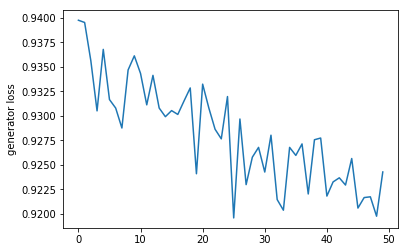

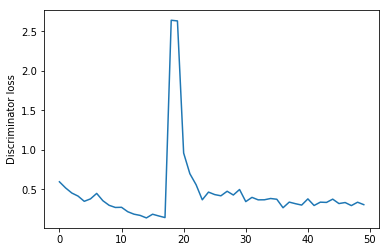

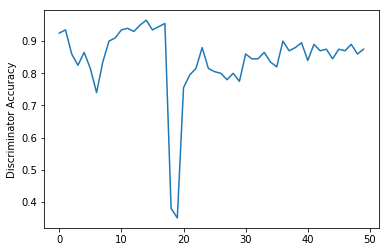

In [12]:
d = dec.reshape(batch_size,28,28)[50:100,:,:]#Next 50 images
show_images(d.tolist(), 5)
import matplotlib.pyplot as plt

plt.plot(generator_loss)
plt.ylabel("generator loss")
plt.show()
plt.plot(discriminator_loss)
plt.ylabel("Discriminator loss")
plt.show()
# print(discriminator_acc)
plt.plot(discriminator_acc)
plt.ylabel("Discriminator Accuracy")
plt.show()

